In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')
sns.set_theme()



In [2]:
%cd ..

/home/belu/VS Workplace/licentiate-thesis-repo


In [3]:
import src.data.notebook_utils as utils

In [4]:
validation_amine = "data/preproccess/only_one_amine.csv"

df_validation_amine = pd.read_csv(validation_amine)
#df_test = df_test_full[rxn_feat+continous_feat]

df_validation_amine["_out_crystalscore"].value_counts()

0    1356
1     313
Name: _out_crystalscore, dtype: int64

In [7]:
df_all_training_amine = utils.read_data(organic_key=False)
df_all_amines = pd.concat([df_all_training_amine, df_validation_amine], axis=0).reset_index()

In [10]:
df_all_training_amine.groupby(by="Chemical Abbreviation").size()

Chemical Abbreviation
4FluoroPhenethylammoniumIodide          140
4FluoroPhenylammoniumIodide              93
4MethoxyPhenylammoniumIodide            136
4TrifluoromethylBenzylammoniumIodide     91
4TrifluoromethylPhenylammoniumIodide     92
4methoxyphenethylammoniumiodide          89
BenzylammoniumIodide                    169
CyclohexylmethylammoniumIodide           93
Diethylammoniumiodide                    93
Diisopropylammoniumiodide                93
FormamidiniumIodide                     205
GnNH3I                                  359
IPentylammoniumIodide                    91
ImidazoliumIodide                       185
MeNH3I                                  132
NNDiethylpropane13diammoniumiodide       92
NPropylammoniumIodide                   136
PhEtNH3I                                 91
PhenylammoniumIodide                     90
TertOctylammoniumIodide                  92
iButylammoniumIodide                    273
iPropylammoniumIodide                   161
n-BuNH3I  

In [10]:
df_all_amines["_out_crystalscore"].value_counts()

0    4303
1     996
Name: _out_crystalscore, dtype: int64

In [11]:
groups = df_all_amines["Chemical Abbreviation"] 
#df_all = df_all.drop(["_rxn_mixingtime2S", "_rxn_stirrateRPM", "_rxn_mixingtime1S", "_rxn_reactiontimeS", "_rxn_organic-inchikey"], axis=1)
#df_all['_out_crystalscore'] = (df_all['_out_crystalscore'] == 4).astype(int)

In [12]:


scoring_sample = {"matt": make_scorer(matthews_corrcoef)}
#, "precision": make_scorer(precision_score),
 #                "recall": make_scorer(recall_score), "f1": make_scorer(f1_score)
  #               }

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 

def run_smote_with(df, model):
    X = df.drop(['_out_crystalscore'], axis=1)
    y = df['_out_crystalscore']

    # define model
    ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    adasyn = [('std', StandardScaler()), ('ada', ada), ('model', model)] 
    border_steps = [('std', StandardScaler()), ('over', BorderlineSMOTE(sampling_strategy=0.4)), ('model', model)] 
    steps_both = [('std', StandardScaler()), ('over', SMOTE(sampling_strategy=0.4)), ('under', under), ('model', model)] 
    steps = [('std', StandardScaler()), ('over', SMOTE(sampling_strategy=0.5)), ('model', model)]
    steps_no_smote = [('std', StandardScaler()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline_no_smote = Pipeline(steps=steps_no_smote)
    pipeline_both = Pipeline(steps=steps_both)
    pipeline_border = Pipeline(steps=border_steps)
    pipeline_ada = Pipeline(steps=adasyn)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=40, random_state=2)
    scores = cross_validate(pipeline, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_no_smote = cross_validate(pipeline_no_smote, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_both = cross_validate(pipeline_both, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_border = cross_validate(pipeline_border, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_ada = cross_validate(pipeline_ada, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    dtm = pd.DataFrame(scores_both).join(pd.DataFrame(scores), lsuffix='_smote_under', rsuffix='_smote')
    results = dtm.join(pd.DataFrame(scores_no_smote), lsuffix='', rsuffix='_original_sampling')
    results_ada = results.join(pd.DataFrame(scores_ada), lsuffix='', rsuffix='_adasyn')
    final_results = results_ada.join(pd.DataFrame(scores_border), lsuffix='', rsuffix='_border_sampling')
    return (final_results.loc[:, final_results.columns.str.startswith('test')]).sort_index(axis=1)

def get_summary_exp_sampling_for_model_and_data(df, model):
    full_results = run_smote_with(df, model)
    full_results.columns = pd.MultiIndex.from_product(
                iterables=[["F1", "MCC", "Precisión", "Recall"], ["Sin Balanceo", "ADASYN", "SMOTE-Borde", "SMOTE", "SMOTE-Sub"]], 
                names=['Métrica', 'Método Balanceo'])
    return full_results

metrics_col = ["F1", "MCC", "Precisión", "Recall"]
hue_col = "Método Balanceo"

def boxplots_compared_columns_for_model(df, title, columns, hue_col, ylim=(0.6,0.9)):
    df = df.stack(level=1).reset_index(level=0, drop=True).reset_index()
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    fig.suptitle(title)

    plt.setp(axes, xlim=ylim)
    for num, column in enumerate(columns):
        sns.boxplot(ax=axes[num], x=column, y=hue_col, data=df, showfliers = False, 
            #medianprops=dict(color="yellow", alpha=1),
            linewidth=0.95)
        sns.swarmplot(ax=axes[num], x=column, y=hue_col, data=df, color="black", size=1.3)
        axes[num].set(ylabel=None)

def boxplot_all_columns_summary(df):
    sns.boxplot(data=df, orient="h")
    plt.show() 

In [14]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

def grid_search_best_model_for(df, model, param_grid, adasyn=False):
    X = df.drop(['_out_crystalscore'], axis=1)
    y = df['_out_crystalscore']

    pipeline_steps = [('std', StandardScaler()), ('model', model)]

    # define model
    if(adasyn):
        ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
        pipeline_steps = [('std', StandardScaler()), ('ada', ada), ('model', model)]

    pipeline = Pipeline(steps=pipeline_steps)

    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=2)

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring_sample, n_jobs=-1, refit="matt")

    clf.fit(X,y)

    return clf

def print_confusion_matrix(y_test, y_pred, title=""):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['Verdadero Negativo \n`No Cristaliza`', 'Falso Negativo:\n Errado `No Cristaliza`', 'Falso Positivo:\n Errado Cristaliza', 'Verdadero Positivo: \n Cristaliza']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  matt = matthews_corrcoef(y_test, y_pred)
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Blues")
  ax.set_title(title)
  stats_text = "\n Matthews={:0.3f}\nAccuracy={:0.3f}\nPrecisión={:0.3f}\nRecall={:0.3f}\nF1={}".format(matt, accuracy, precision, recall, f1_score)
  plt.ylabel('Etiqueta Verdadera')
  plt.xlabel('Etiqueta Predecida' + stats_text)

  
def testing_data_confusion_matrix(df_test, clf, title):
    X_test = df_test.drop(['_out_crystalscore'], axis=1)
    y_test = df_test['_out_crystalscore']

    y_pred = clf.predict(X_test)
    print_confusion_matrix(y_test, y_pred, title)  


In [15]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

In [16]:
def group_one_out(X, y, groups, model):
    miss_rates = []
    amines = []
    tp = []
    tn = []
    fp = []
    fn = []
    ratios = []
    recall = []
    positive_metric = []
    accuraries = []
    rec_mic = []
    rec_weight = []
    f1_weight = []
    f1_mac = []
    f1_mic = []
    f1_naive = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train = X.loc[train_index]
        y_train = y.loc[train_index]

        X_test = X.loc[test_index]
        y_test = y.loc[test_index]

        counts = y_test.value_counts()

        if(len(counts)>1): ratio = counts.iloc[1]/(counts.iloc[1]+counts.iloc[0])
        else: ratio = 0

        amine = groups.loc[test_index].iloc[0]
        amines.append(amine)
        ratios.append(ratio)
        
        pipeline_steps = [('std', StandardScaler()), ('model', model)]

        clf = Pipeline(steps=pipeline_steps)

        #cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2
        #clf = GridSearchCV(pipeline, param_grid=param_grid_rf, cv=cv, scoring=scoring_sample, n_jobs=-1, refit="matt")

        clf.fit(X_train,y_train)

        y_pred = clf.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])

        f1_weight.append(f1_score(y_test, y_pred, labels=[0,1], average="weighted", zero_division=1))
        f1_mic.append(f1_score(y_test, y_pred, labels=[0,1], average="micro", zero_division=1))
        f1_mac.append(f1_score(y_test, y_pred, labels=[0,1], average="macro", zero_division=1))
        f1_naive.append(f1_score(y_test, y_pred, average=None, zero_division=1))

        rec_weight.append(recall_score(y_test, y_pred, labels=[0,1], average="weighted", zero_division=1))
        rec_mic.append(recall_score(y_test, y_pred, labels=[0,1], average="micro", zero_division=1))
        miss_rates.append(recall_score(y_test, y_pred, labels=[0,1], average="macro", zero_division=1))
        recall.append(recall_score(y_test, y_pred, average=None, labels=[0,1], zero_division=0)[1])
        positive_metric.append(precision_score(y_test, y_pred, labels=[0,1], average="macro"))
        #positive_metric.append(precision(cf_matrix))
        accuraries.append(accuracy_score(y_test, y_pred, normalize=True))

        tp.append(cf_matrix[1,1])
        tn.append(cf_matrix[0,0])
        fp.append(cf_matrix[0,1])
        fn.append(cf_matrix[1,0])

    df_results = pd.DataFrame.from_dict({"amine": amines,
                                        "recall_positive_naive": recall, 
                                        "rec_mac": miss_rates,
                                        "rec_mic": rec_mic, 
                                        "rec_wei": rec_weight, 
                                        "f1_naive": f1_naive,
                                        "f1_mac": f1_mac,
                                        "f1_mic": f1_mic,
                                        "f1_wie": f1_weight,
                                        "tn": tn, 
                                        "fp":fp, 
                                        "tp":tp, 
                                        "fn":fn})
    df_results["recall"] = recall 
    df_results["precision"] = positive_metric 
    df_results["accuracy"] = accuraries 
    return df_results


In [17]:
X = df_all_amines[utils.rxn_feat + utils.continous_feat]
y = df_all_amines['_out_crystalscore']

param_grid_rf = { 
    'model__max_depth': [5,8],
    'model__min_samples_leaf': [3,6]
}

k_range = [2,5,0]
param_grid_rf = {  "model__n_neighbors": k_range, 
            }

groups_amines = df_all_amines.groupby(by="Chemical Abbreviation")["_out_crystalscore"]
amines_crystal_ratio = groups_amines.sum()/groups_amines.count()

def plot_group_out_proportion(df):
    df["ratio"] = amines_crystal_ratio.values
    plt.rcParams['figure.figsize'] = [12, 6]
    ax = df.plot(x="amine", y=["matt", "ratio"], kind="bar")
    ax.tick_params(axis='x', rotation=90)


In [18]:
knn = KNeighborsClassifier(weights="distance", n_jobs=-1)
df_knn_GOO = group_one_out(X,y, groups, knn)
df_knn_GOO["ratio"] = amines_crystal_ratio.values
#df_knn_GOO["Recall/precision"] = (df_knn_GOO["miss_rate"]+df_knn_GOO["precision"])/2
#df_knn_GOO.sort_values(by="Recall/precision")

In [19]:
df_knn_GOO.sort_values(by="ratio")

,amine,recall_positive_naive,rec_mac,rec_mic,rec_wei,f1_naive,f1_mac,f1_mic,f1_wie,tp,tn,fp,fn,recall,precision,accuracy,ratio
13,IPentylammoniumIodide,0.000000,0.994505,0.989011,0.989011,"[0.994475138121547, 0.0]",0.497238,0.989011,0.994475,0,90,1,0,0.000000,0.500000,0.989011,0.000000
20,TertOctylammoniumIodide,0.000000,1.000000,1.000000,1.000000,[1.0],1.000000,1.000000,1.000000,0,92,0,0,0.000000,0.500000,1.000000,0.000000
24,nDodecylammoniumIodide,0.000000,1.000000,1.000000,1.000000,[1.0],1.000000,1.000000,1.000000,0,136,0,0,0.000000,0.500000,1.000000,0.000000
17,NPropylammoniumIodide,0.000000,1.000000,1.000000,1.000000,[1.0],1.000000,1.000000,1.000000,0,136,0,0,0.000000,0.500000,1.000000,0.000000
8,Diethylammoniumiodide,0.000000,1.000000,1.000000,1.000000,[1.0],1.000000,1.000000,1.000000,0,93,0,0,0.000000,0.500000,1.000000,0.000000
6,BenzylammoniumIodide,0.000000,1.000000,1.000000,1.000000,[1.0],1.000000,1.000000,1.000000,0,169,0,0,0.000000,0.500000,1.000000,0.000000
9,Diisopropylammoniumiodide,0.000000,0.967742,0.935484,0.935484,"[0.9666666666666666, 0.0]",0.483333,0.935484,0.966667,0,87,6,0,0.000000,0.500000,0.935484,0.000000
3,4TrifluoromethylBenzylammoniumIodide,0.000000,0.967033,0.934066,0.934066,"[0.9659090909090909, 0.0]",0.482955,0.934066,0.965909,0,85,6,0,0.000000,0.500000,0.934066,0.000000
5,4methoxyphenethylammoniumiodide,0.000000,0.971910,0.943820,0.943820,"[0.9710982658959537, 0.0]",0.485549,0.943820,0.971098,0,84,5,0,0.000000,0.500000,0.943820,0.000000
18,PhEtNH3I,0.000000,0.989011,0.978022,0.978022,"[0.9888888888888888, 0.0]",0.494444,0.978022,0.988889,0,89,2,0,0.000000,0.500000,0.978022,0.000000


In [17]:
rf = RandomForestClassifier(n_jobs=-1, random_state=1, max_depth=5, min_samples_leaf=3)

In [18]:
""" rf = RandomForestClassifier(n_jobs=-1, random_state=1, max_depth=5, min_samples_leaf=3)
df_rf_GOO = group_one_out(X,y, groups, rf)
df_rf_GOO["ratio"] = amines_crystal_ratio.values """

' rf = RandomForestClassifier(n_jobs=-1, random_state=1, max_depth=5, min_samples_leaf=3)\ndf_rf_GOO = group_one_out(X,y, groups, rf)\ndf_rf_GOO["ratio"] = amines_crystal_ratio.values '

<AxesSubplot:title={'center':'KNN: Extrapolación'}, xlabel='Positive Recall', ylabel='Precision'>

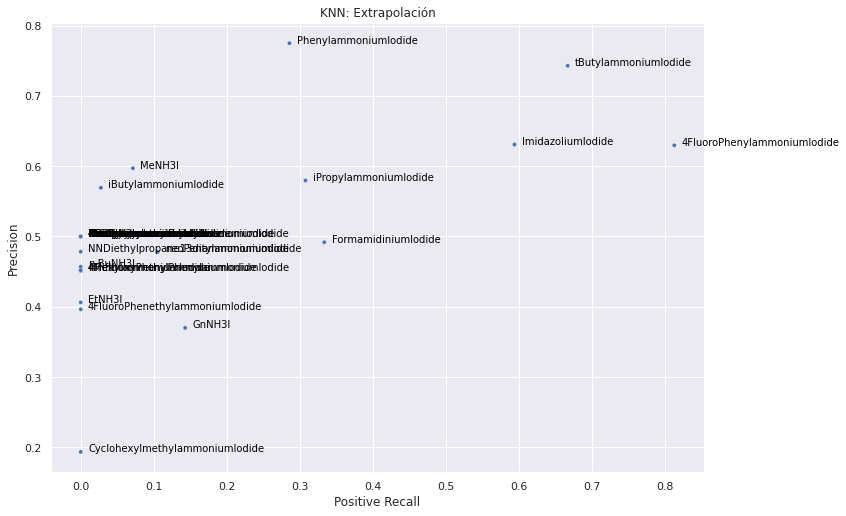

In [24]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
scatter_text("recall_positive_naive", "precision", "amine", df_knn_GOO, "KNN: Extrapolación", "Positive Recall", "Precision",df_knn_GOO.index)


In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
scatter_text("recall_positive_naive", "precision", "amine", df_knn_GOO, "KNN: Extrapolación", "Positive Recall", "Precision",df_knn_GOO.index)


<AxesSubplot:title={'center':'KNN: Extrapolación'}, xlabel='Positive Recall Macro', ylabel='Precision'>

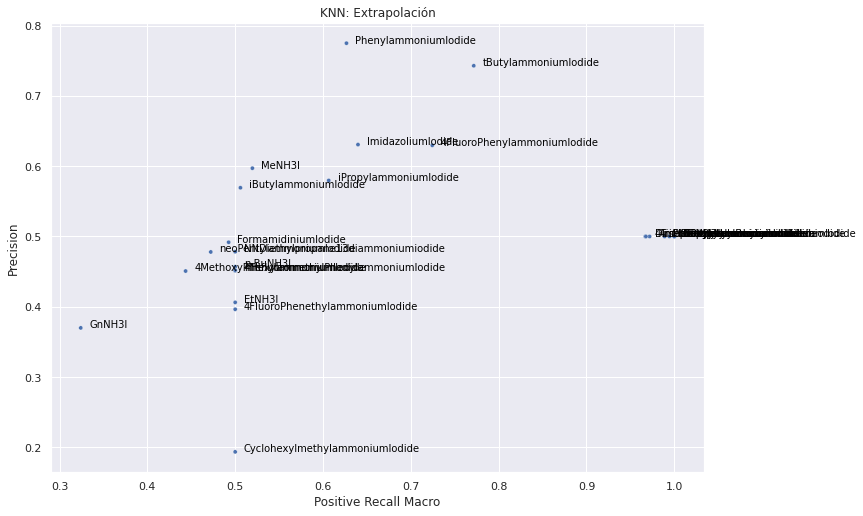

In [27]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
scatter_text("rec_mac", "precision", "amine", df_knn_GOO, "KNN: Extrapolación", "Positive Recall Macro", "Precision",df_knn_GOO.index)


In [ ]:
scatter_text("recall_positive_naive", "precision", "amine", df_knn_GOO, "KNN: Extrapolación", "Positive Recall", "Precision",df_knn_GOO.index)


In [25]:
gbc = GradientBoostingClassifier(random_state=1, min_samples_leaf=3)
df_gfc_GOO = group_one_out(X,y, groups, gbc)

In [26]:
df_gfc_GOO["ratio"] = amines_crystal_ratio.values
df_gfc_GOO
# casos 21/22 y 26/27
# post modelos 

,amine,miss_rate,tp,tn,fp,fn,recall,ratio
0,4FluoroPhenethylammoniumIodide,0.500000,0,111,0,29,"[1.0, 0.0]",0.207143
1,4FluoroPhenylammoniumIodide,0.661932,11,49,28,5,"[0.6363636363636364, 0.6875]",0.172043
2,4MethoxyPhenylammoniumIodide,0.500000,0,124,0,12,"[1.0, 0.0]",0.088235
3,4TrifluoromethylBenzylammoniumIodide,1.000000,0,91,0,0,[1.0],0.000000
4,4TrifluoromethylPhenylammoniumIodide,0.500000,0,83,0,9,"[1.0, 0.0]",0.097826
5,4methoxyphenethylammoniumiodide,1.000000,0,89,0,0,[1.0],0.000000
6,BenzylammoniumIodide,0.985207,0,164,5,0,"[0.9704142011834319, 1.0]",0.000000
7,CyclohexylmethylammoniumIodide,0.500000,0,36,0,57,"[1.0, 0.0]",0.612903
8,Diethylammoniumiodide,1.000000,0,93,0,0,[1.0],0.000000
9,Diisopropylammoniumiodide,1.000000,0,93,0,0,[1.0],0.000000


In [21]:
""" scatter_text("miss_rate", "ratio", "amine", df_gfc_GOO, "Relación Recall-Positive Ratio", "recall", "positive rate", df_gfc_GOO.index)
 """

' scatter_text("miss_rate", "ratio", "amine", df_gfc_GOO, "Relación Recall-Positive Ratio", "recall", "positive rate", df_gfc_GOO.index)\n '

,amine,miss_rate,tp,tn,fp,fn,recall,ratio
0,4FluoroPhenethylammoniumIodide,0.500000,0,111,0,29,"[1.0, 0.0]",0.207143
1,4FluoroPhenylammoniumIodide,0.724432,13,49,28,3,"[0.6363636363636364, 0.8125]",0.172043
2,4MethoxyPhenylammoniumIodide,0.443548,0,110,14,12,"[0.8870967741935484, 0.0]",0.088235
3,4TrifluoromethylBenzylammoniumIodide,0.967033,0,85,6,0,"[0.9340659340659341, 1.0]",0.000000
4,4TrifluoromethylPhenylammoniumIodide,0.500000,0,83,0,9,"[1.0, 0.0]",0.097826
5,4methoxyphenethylammoniumiodide,0.971910,0,84,5,0,"[0.9438202247191011, 1.0]",0.000000
6,BenzylammoniumIodide,1.000000,0,169,0,0,[1.0],0.000000
7,CyclohexylmethylammoniumIodide,0.500000,0,36,0,57,"[1.0, 0.0]",0.612903
8,Diethylammoniumiodide,1.000000,0,93,0,0,[1.0],0.000000
9,Diisopropylammoniumiodide,0.967742,0,87,6,0,"[0.9354838709677419, 1.0]",0.000000


In [ ]:
scatter_text("miss_rate", "ratio", "amine", df_knn_GOO, "title", "recall", "positive rate", amines_to_plot)


In [21]:
from adjustText import adjust_text

def scatter_text(x, y, text_column, data, title, xlabel, ylabel, index_to_plot):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    texts = []
    # Add text besides each point
    for line in index_to_plot:
      #texts.append(p1.text(data[x][line]+0.01, data[y][line], data[text_column][line]))
      p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='small', color='black')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #adjust_text(texts, data[[text_column]])
    return p1

In [106]:
df_knn_GOO["amines_plot"] = df_knn_GOO["amine"] 

df_knn_GOO.loc[df_knn_GOO['ratio'] == 0, 'amines_plot'] = "Grupo que no cristaliza"

In [114]:
amines_to_plot = list(df_knn_GOO.loc[df_knn_GOO['ratio'] > 0, 'amines_plot'].index)+[8]

<AxesSubplot:title={'center':'KNN: Recall/Cristalization ratio'}, xlabel='recall', ylabel='positive rate'>

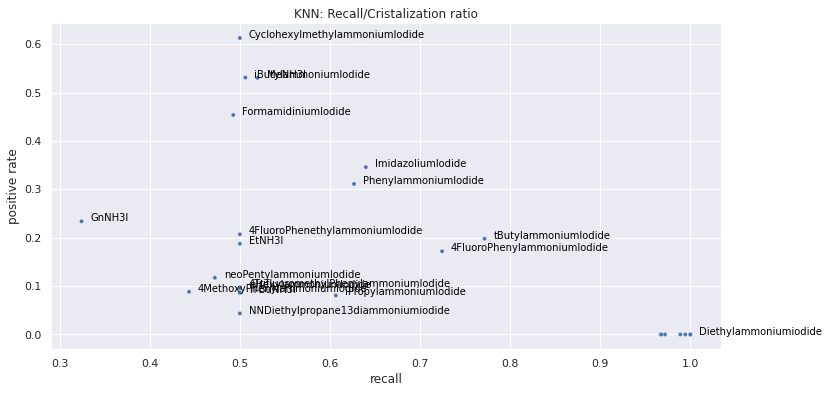

In [183]:
scatter_text("miss_rate", "ratio", "amine", df_knn_GOO, "KNN: Recall/Cristalization ratio", "recall", "positive rate", amines_to_plot)

In [198]:
import plotly.express as px
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)


def scatter_reactions(df, title, amines, symbols):
    fig = px.scatter_3d(df, x=organic, y=inorganic, z = acid, 
                        color=amines, width=1200, height=800, symbol=symbols, 
                        size=[10 for _ in range(0,len(df))], size_max=13)
    fig.update_layout(
        legend=dict(
            title="Amina",
        )
    )

    fig.update_layout(title={
                        'text': title,
                        'y':0.9,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'})
    fig.show()

In [161]:
organic = "_rxn_M_organic"
inorganic = "_rxn_M_inorganic"
acid = "_rxn_M_acid"
amines = df_all_amines["Chemical Abbreviation"]
crystal_out = "_out_crystalscore"


In [209]:
good_learning_amines = df_knn_GOO.loc[(df_knn_GOO["miss_rate"] > 0.6) & (df_knn_GOO["ratio"] > 0.1)]["amine"].values
crystal_imbalanced_amines = df_knn_GOO.loc[(df_knn_GOO["ratio"] > 0.15)]["amine"].values
bad_learning_amines = df_knn_GOO.loc[df_knn_GOO["ratio"] > 0.4]["amine"].values

scatter_reaction_title = 'Concentraciones de cristalización'

def scatter_selected_amines(selected_amines, title):
    df = df_all_amines.loc[df_all_amines['Chemical Abbreviation'].isin(selected_amines)]
    scatter_reactions(df[utils.rxn_feat + utils.continous_feat], title=scatter_reaction_title+ " " + title, 
                    amines=df["Chemical Abbreviation"],symbols=df[crystal_out])
                    

In [204]:
scatter_selected_amines(good_learning_amines, title = "Aminas extrapoladas")

In [205]:
scatter_selected_amines(crystal_imbalanced_amines, title = "Aminas con target desbalanceado")

In [210]:
scatter_selected_amines(bad_learning_amines, title = "Aminas no extrapoladas")